# EDA

In [4]:
#!pip install xarray zarr dask lightning matplotlib wandb cftime einops nc-time-axis

In [ ]:
#!pip install nc-time-axis

In [7]:
import zarr
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

In [8]:
import seaborn as sns

In [9]:
# Load the data (update the path to the correct location)
data_path = "/kaggle/input/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr"
#data_path = "path/to/data/processed_data_cse151b_v2_corrupted_ssp245.zarr"
data = xr.open_zarr(data_path)
data

<xarray.Dataset> Size: 621MB
Dimensions:    (ssp: 4, time: 1021, latitude: 48, longitude: 72, x: 72, y: 48,
                member_id: 3)
Coordinates:
    lat        (x, y) float64 28kB dask.array<chunksize=(72, 48), meta=np.ndarray>
  * latitude   (latitude) float64 384B -89.05 -85.26 -81.47 ... 85.26 89.05
    lon        (x, y) float64 28kB dask.array<chunksize=(72, 48), meta=np.ndarray>
  * longitude  (longitude) float64 576B 1.25 6.25 11.25 ... 346.2 351.2 356.2
  * member_id  (member_id) int64 24B 0 1 2
  * ssp        (ssp) <U6 96B 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * time       (time) object 8kB 2015-01-15 00:00:00 ... 2100-01-15 00:00:00
  * x          (x) float64 576B 1.875 6.875 11.88 16.88 ... 346.9 351.9 356.9
  * y          (y) float64 384B -88.59 -84.82 -81.05 ... 81.05 84.82 88.59
Data variables:
    BC         (ssp, time, latitude, longitude) float64 113MB dask.array<chunksize=(1, 24, 48, 72), meta=np.ndarray>
    CH4        (ssp, time) float64 33kB dask.array<chunksize=(1, 24), meta=np.ndarray>
    CO2        (ssp, time) float64 33kB dask.array<chunksize=(1, 24), meta=np.ndarray>
    SO2        (ssp, time, latitude, longitude) float64 113MB dask.array<chunksize=(1, 24, 48, 72), meta=np.ndarray>
    pr         (ssp, time, member_id, y, x) float32 169MB dask.array<chunksize=(1, 24, 1, 48, 72), meta=np.ndarray>
    rsdt       (ssp, time, y, x) float32 56MB dask.array<chunksize=(1, 24, 48, 72), meta=np.ndarray>
    tas        (ssp, time, member_id, y, x) float32 169MB dask.array<chunksize=(1, 24, 1, 48, 72), meta=np.ndarray>
Attributes:
    original_member_ids:  ['r10i1p1f1', 'r11i1p1f1', 'r4i1p1f1']
    precipitation_units:  mm/day (converted from kg m-2 s-1)
    source:               CMIP6 data processed for CSE151B
    ssp:                  ssp126

In [10]:
ds = data

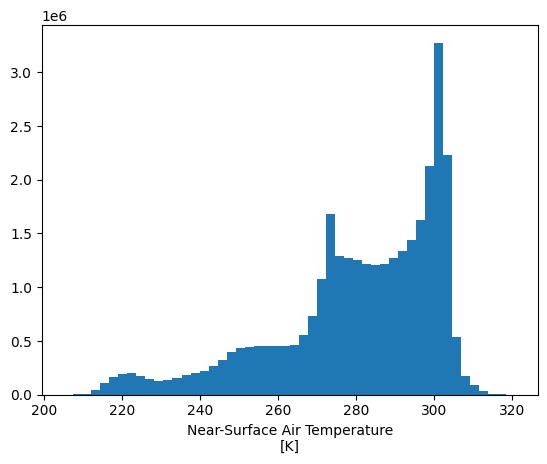

In [22]:
data.sel(ssp=["ssp126", "ssp370", "ssp585"]).tas.plot.hist(bins=50);

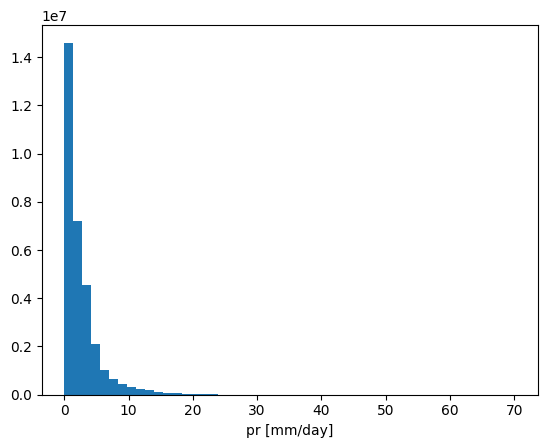

In [25]:
data.sel(ssp=["ssp126", "ssp370", "ssp585"]).pr.plot.hist(bins=50);

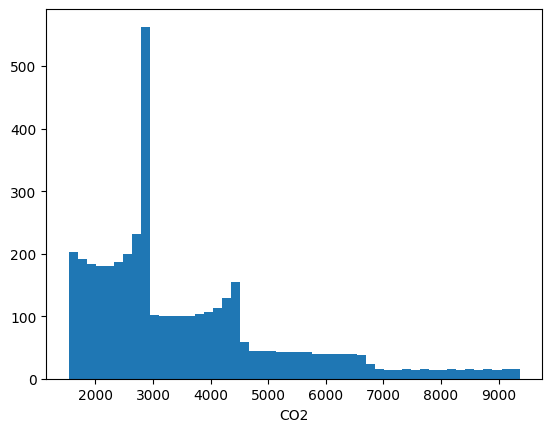

In [8]:
data.CO2.plot.hist(bins=50);

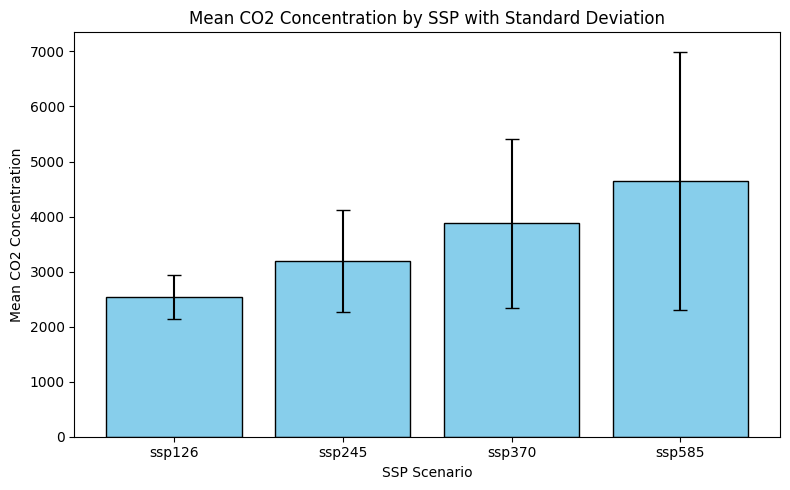

In [27]:

# Get CO2 mean and standard deviation along time dimension
co2 = ds['CO2']
co2_mean = co2.mean(dim='time')
co2_std = co2.std(dim='time')

# Extract labels and values
ssp_labels = ds['ssp'].values
co2_mean_values = co2_mean.values
co2_std_values = co2_std.values

# Plot with error bars
plt.figure(figsize=(8, 5))
plt.bar(ssp_labels, co2_mean_values, yerr=co2_std_values, capsize=5, color='skyblue', edgecolor='black')
plt.xlabel('SSP Scenario')
plt.ylabel('Mean CO2 Concentration')
plt.title('Mean CO2 Concentration by SSP with Standard Deviation')
plt.tight_layout()
plt.show()


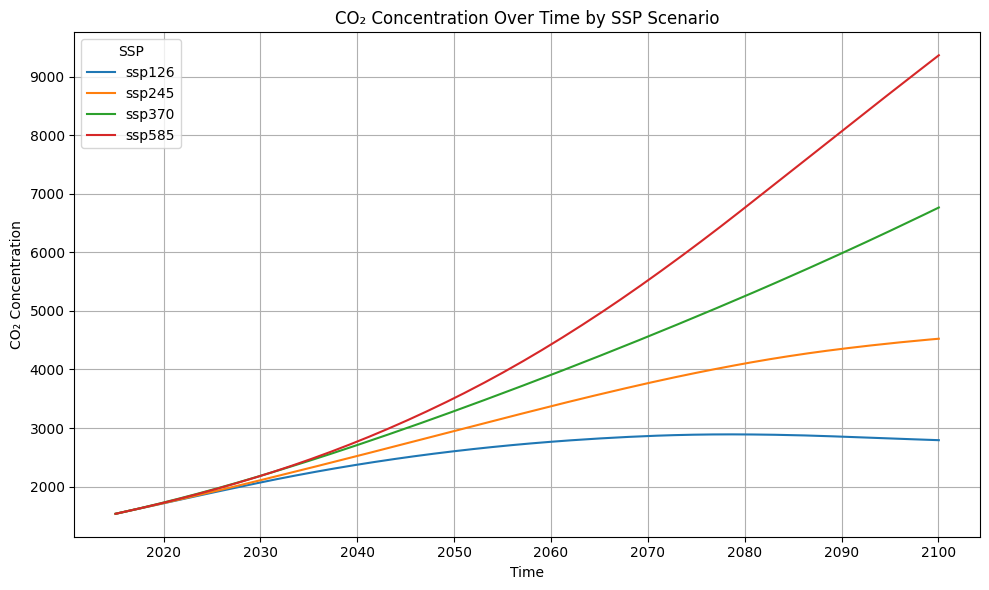

In [44]:

# CO2 has dimensions: (ssp, time)
co2 = ds['CO2']
ssp_labels = ds['ssp'].values

# Convert cftime to native datetime64 for plotting
time = ds['time'].dt.strftime('%Y-%m-%d').values.astype('datetime64[D]')

# Plot
plt.figure(figsize=(10, 6))
for ssp in ssp_labels:
    co2_series = co2.sel(ssp=ssp)
    plt.plot(time, co2_series, label=ssp)

plt.xlabel('Time')
plt.ylabel('CO₂ Concentration')
plt.title('CO₂ Concentration Over Time by SSP Scenario')
plt.legend(title='SSP')
plt.grid(True)
plt.tight_layout()
plt.show()


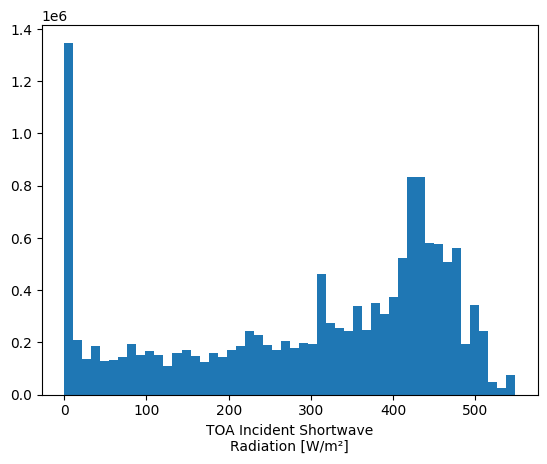

In [9]:
data.rsdt.plot.hist(bins=50);

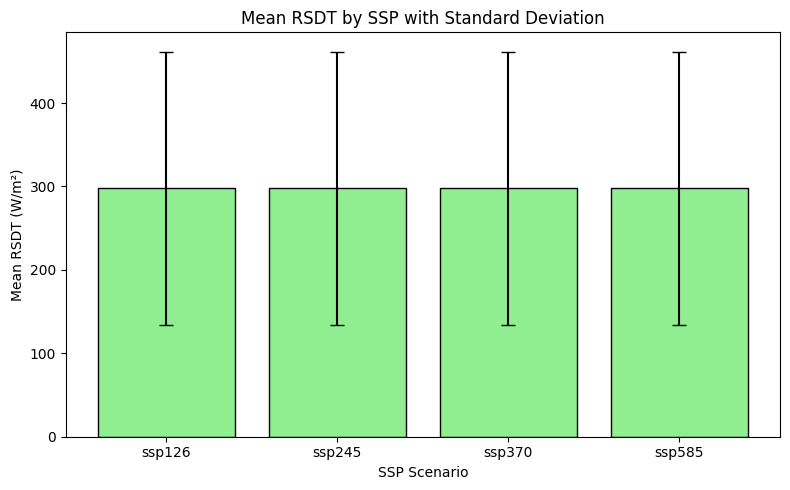

In [31]:
# rsdt dimensions: (ssp, time, y, x)
# If there's a 'member_id' dimension, include it too:
dims_to_avg = ['time', 'y', 'x']
if 'member_id' in ds['rsdt'].dims:
    dims_to_avg.append('member_id')

# Compute mean and std over spatial and temporal dimensions
rsdt = ds['rsdt']
rsdt_mean = rsdt.mean(dim=dims_to_avg)
rsdt_std = rsdt.std(dim=dims_to_avg)

# Extract SSP labels and values
ssp_labels = ds['ssp'].values
rsdt_mean_values = rsdt_mean.values
rsdt_std_values = rsdt_std.values

# Plot with error bars
plt.figure(figsize=(8, 5))
plt.bar(ssp_labels, rsdt_mean_values, yerr=rsdt_std_values, capsize=5, color='lightgreen', edgecolor='black')
plt.xlabel('SSP Scenario')
plt.ylabel('Mean RSDT (W/m²)')
plt.title('Mean RSDT by SSP with Standard Deviation')
plt.tight_layout()
plt.show()


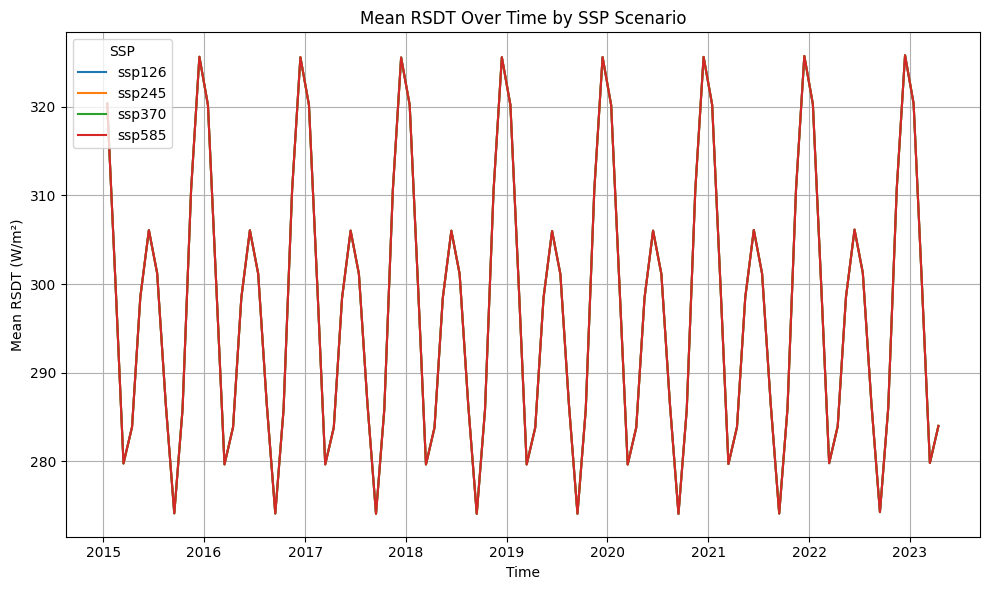

In [51]:

# Select rsdt and determine dims to average over
rsdt = ds['rsdt']
dims_to_avg = ['y', 'x']
if 'member_id' in rsdt.dims:
    dims_to_avg.append('member_id')

# Compute spatial mean: result is (ssp, time)
rsdt_mean = rsdt.mean(dim=dims_to_avg)

# Convert cftime time to datetime64 for plotting
time = pd.to_datetime(ds['time'].values.astype(str))

# Extract SSP labels
ssp_labels = ds['ssp'].values

# Plot
plt.figure(figsize=(10, 6))
for ssp in ssp_labels:
    plt.plot(time[:100], rsdt_mean.sel(ssp=ssp)[:100], label=ssp)

plt.xlabel('Time')
plt.ylabel('Mean RSDT (W/m²)')
plt.title('Mean RSDT Over Time by SSP Scenario')
plt.legend(title='SSP')
plt.grid(True)
plt.tight_layout()
plt.show()


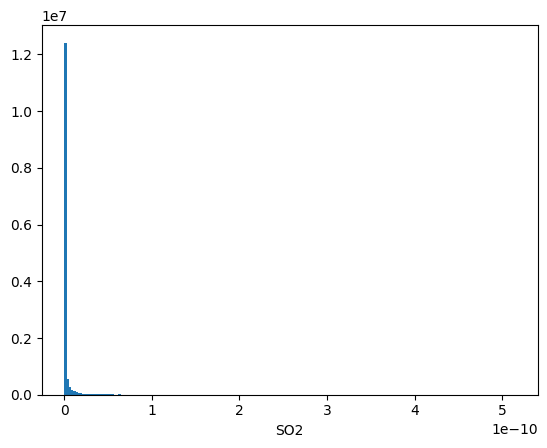

In [40]:
data.SO2.plot.hist(bins=200);

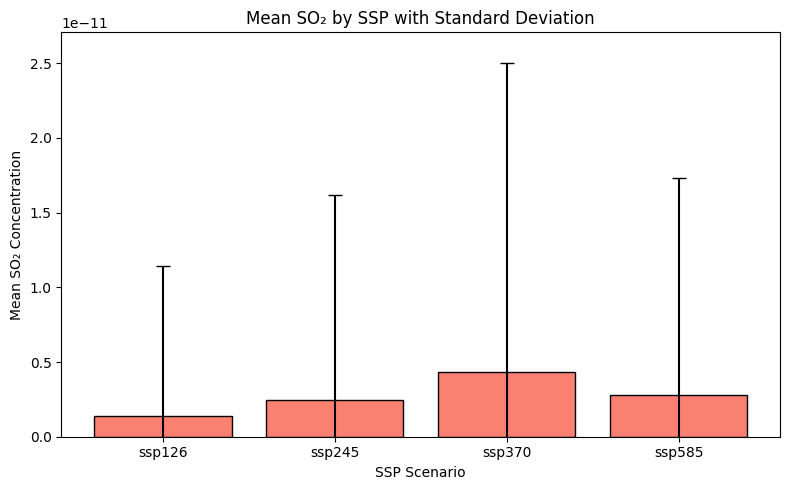

In [42]:
# SO2 dimensions: (ssp, time, latitude, longitude)
so2 = ds['SO2']

# Compute mean and std over time, latitude, and longitude
so2_mean = so2.mean(dim=['time', 'latitude', 'longitude'])
so2_std = so2.std(dim=['time', 'latitude', 'longitude'])

# Extract values for plotting
ssp_labels = ds['ssp'].values
so2_mean_values = so2_mean.values
so2_std_values = so2_std.values

# Plot with error bars
plt.figure(figsize=(8, 5))
plt.bar(ssp_labels, so2_mean_values, yerr=so2_std_values, capsize=5, color='salmon', edgecolor='black')
plt.xlabel('SSP Scenario')
plt.ylabel('Mean SO₂ Concentration')
plt.title('Mean SO₂ by SSP with Standard Deviation')
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()


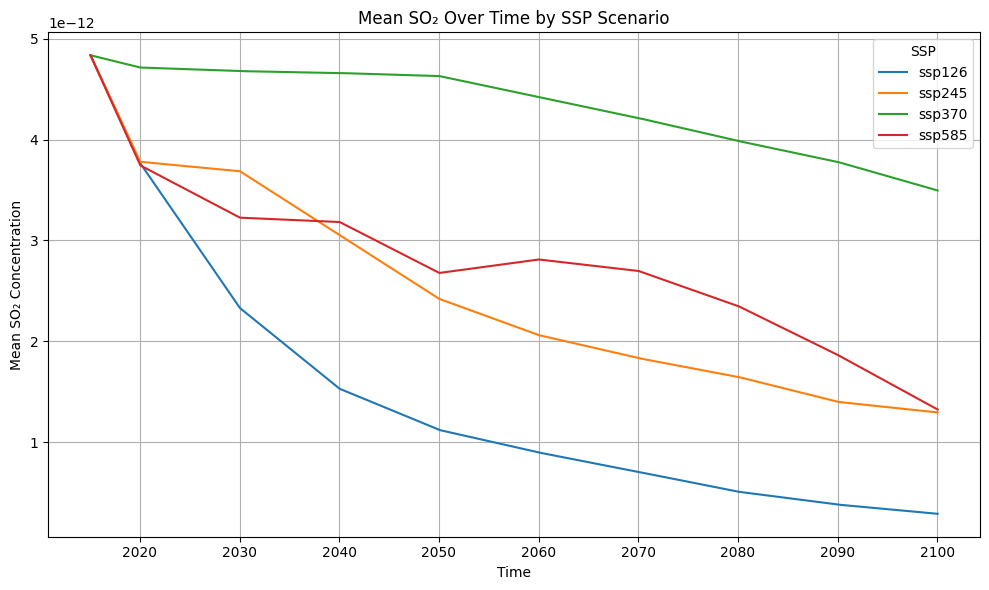

In [52]:
# Select SO2
so2 = ds['SO2']

# Average over spatial dims (latitude, longitude)
so2_mean = so2.mean(dim=['latitude', 'longitude'])

# Convert cftime times to datetime64 for plotting
time = pd.to_datetime(ds['time'].values.astype(str))

# SSP labels
ssp_labels = ds['ssp'].values

# Plot
plt.figure(figsize=(10, 6))
for ssp in ssp_labels:
    plt.plot(time, so2_mean.sel(ssp=ssp), label=ssp)

plt.xlabel('Time')
plt.ylabel('Mean SO₂ Concentration')
plt.title('Mean SO₂ Over Time by SSP Scenario')
plt.legend(title='SSP')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
co2_mean = data.CO2.mean(dim=("ssp"))

co2_yearly = (
    co2_mean
    .groupby("time.year")
    .mean(dim="time")
    .compute()
)

co2_yearly

In [ ]:
co2_mean = data.CO2.mean(dim=("time"))

co2_ssp = (
    co2_mean
    .groupby("ssp")
    .mean(dim="ssp")
    .compute()
)

co2_ssp

In [ ]:
rsdt_mean = data.rsdt.mean(dim=("ssp", "x", "y"))

rsdt_yearly = (
    rsdt_mean
    .groupby("time.year")
    .mean(dim="time")
    .compute()
)

rsdt_yearly

In [ ]:
rsdt_mean = data.rsdt.mean(dim=("time", "x", "y"))

rsdt_ssp = (
    rsdt_mean
    .groupby("ssp")
    .mean(dim="ssp")
    .compute()
)

rsdt_ssp

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


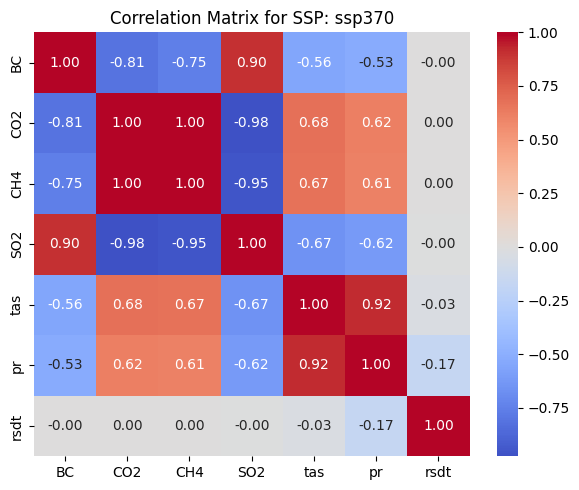

In [71]:

# Select one SSP (e.g., 'ssp245')
ssp_sel = 'ssp370'

# Variables of interest
variables = ['BC', 'CO2', 'CH4', 'SO2', 'tas', 'pr', 'rsdt']

# Dict to store global mean time series for each variable
global_means = {}

for var in variables:
    da = ds[var].sel(ssp=ssp_sel)

    # Determine dimensions to average over
    dims_to_avg = [dim for dim in da.dims if dim not in ['ssp', 'time']]
    global_mean = da.mean(dim=dims_to_avg)
    
    # Save time series to dict
    global_means[var] = global_mean.values

# Convert to DataFrame
time = pd.to_datetime(ds['time'].values.astype(str))
df = pd.DataFrame(global_means, index=time)

# Drop NaNs if any
df = df.dropna()

# Drop any constant columns (zero variance) to avoid NaNs
df = df.loc[:, df.std() > 0]

# Compute correlation matrix
corr = df.corr()

# Plot using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title(f'Correlation Matrix for SSP: {ssp_sel}')
plt.tight_layout()
plt.show()


In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

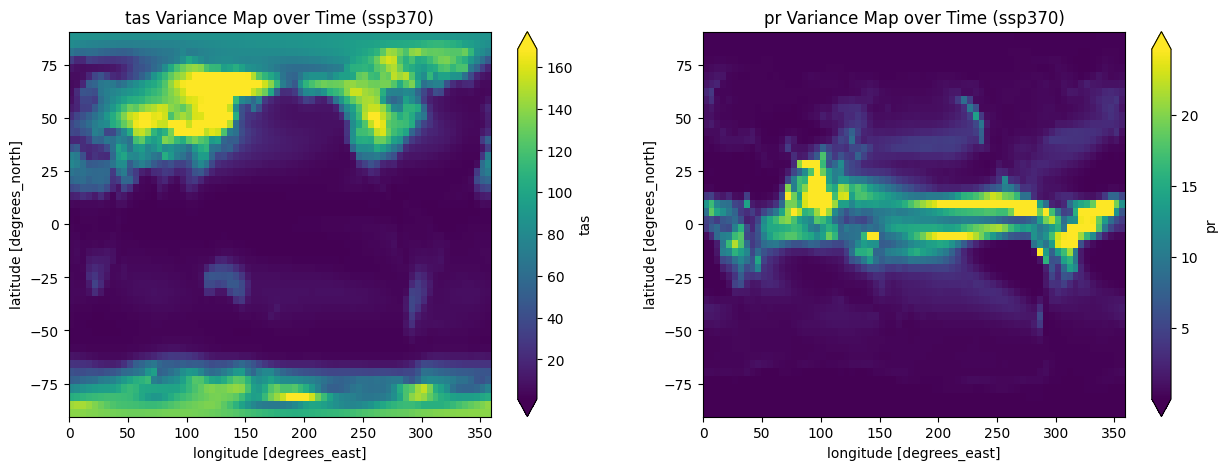

In [28]:
# Select variable, SSP, and optionally average over ensemble members
var = 'tas'
ssp_sel = 'ssp370'

# Extract data
da = data[var].sel(ssp=ssp_sel)

# Average over ensemble members if present (optional)
if 'member_id' in da.dims:
    da = da.mean(dim='member_id')

# Compute variance over time
var_map = da.var(dim='time')

# Plot the variance map
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
var_map.plot(x='x', y='y', ax=ax[0], cmap='viridis', robust=True)
ax[0].set_title(f'{var} Variance Map over Time ({ssp_sel})')
# plt.show()

var = 'pr'
ssp_sel = 'ssp370'

# Extract data
da = data[var].sel(ssp=ssp_sel)

# Average over ensemble members if present (optional)
if 'member_id' in da.dims:
    da = da.mean(dim='member_id')

# Compute variance over time
var_map = da.var(dim='time')

# Plot the variance map
var_map.plot(x='x', y='y', ax=ax[1], cmap='viridis', robust=True)
ax[1].set_title(f'{var} Variance Map over Time ({ssp_sel})')
plt.show()


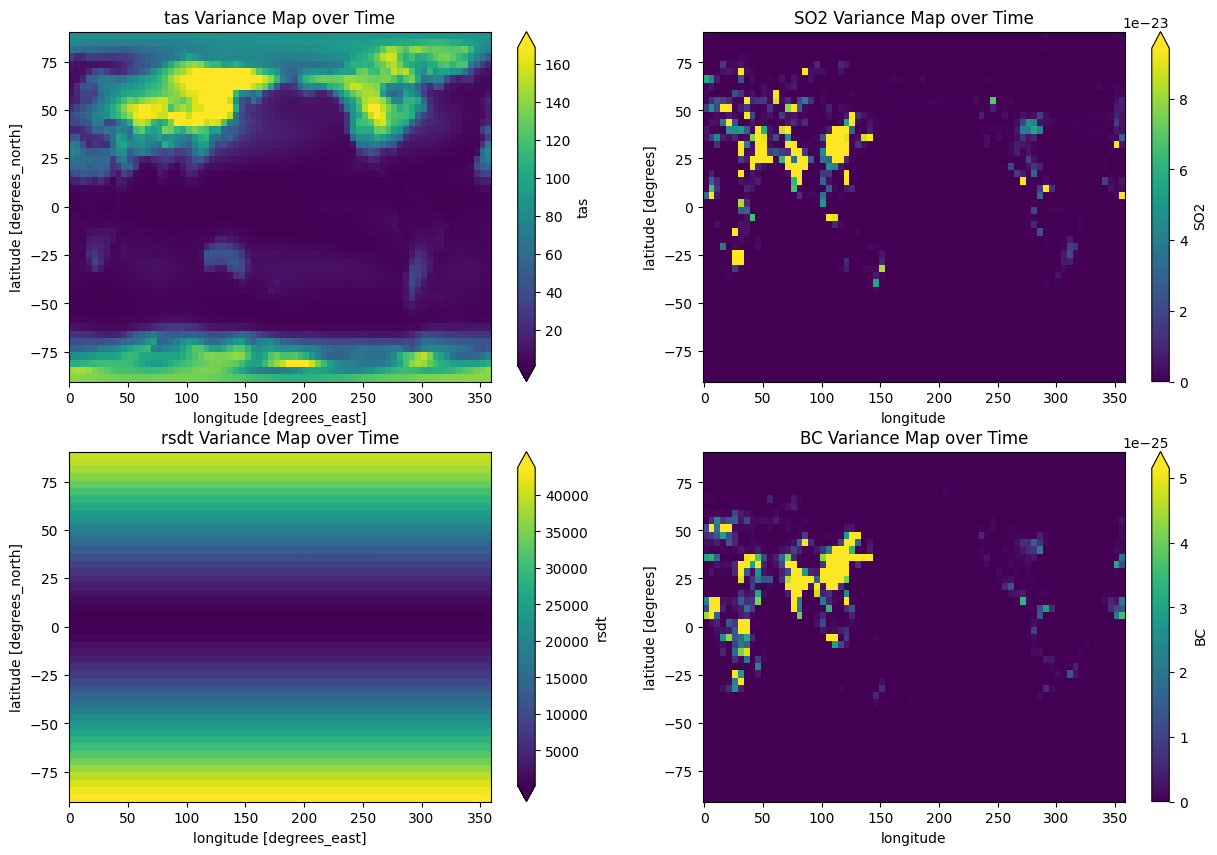

In [57]:
# Select variable, SSP, and optionally average over ensemble members
var = 'tas'
ssp_sel = 'ssp370'

# Extract data
da = data[var].sel(ssp=ssp_sel)

# Average over ensemble members if present (optional)
if 'member_id' in da.dims:
    da = da.mean(dim='member_id')

# Compute variance over time
var_map = da.var(dim='time')

# Plot the variance map
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
var_map.plot(x='x', y='y', ax=ax[0][0], cmap='viridis', robust=True)
ax[0][0].set_title(f'{var} Variance Map over Time')
# plt.show()

var = 'SO2'
ssp_sel = 'ssp370'

# Extract data
da = data[var].sel(ssp=ssp_sel)

# Average over ensemble members if present (optional)
if 'member_id' in da.dims:
    da = da.mean(dim='member_id')

# Compute variance over time
var_map = da.var(dim='time')

# Plot the variance map
var_map.plot(x='longitude', y='latitude', ax=ax[0][1], cmap='viridis', robust=True)
ax[0][1].set_title(f'{var} Variance Map over Time')

var = 'BC'
ssp_sel = 'ssp370'

# Extract data
da = data[var].sel(ssp=ssp_sel)

# Average over ensemble members if present (optional)
if 'member_id' in da.dims:
    da = da.mean(dim='member_id')

# Compute variance over time
var_map = da.var(dim='time')

# Plot the variance map
var_map.plot(x='longitude', y='latitude', ax=ax[1][1], cmap='viridis', robust=True)
ax[1][1].set_title(f'{var} Variance Map over Time')

var = 'rsdt'
ssp_sel = 'ssp370'

# Extract data
da = data[var].sel(ssp=ssp_sel)

# Average over ensemble members if present (optional)
if 'member_id' in da.dims:
    da = da.mean(dim='member_id')

# Compute variance over time
var_map = da.var(dim='time')

# Plot the variance map
var_map.plot(x='x', y='y', ax=ax[1][0], cmap='viridis', robust=True)
ax[1][0].set_title(f'{var} Variance Map over Time')

plt.savefig("everyvar.png")
plt.show()



## Plot a few snapshots of temperature and precipitation (first, middle, and last)

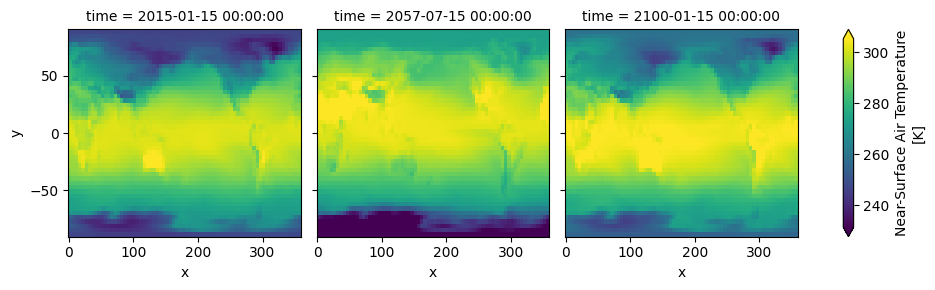

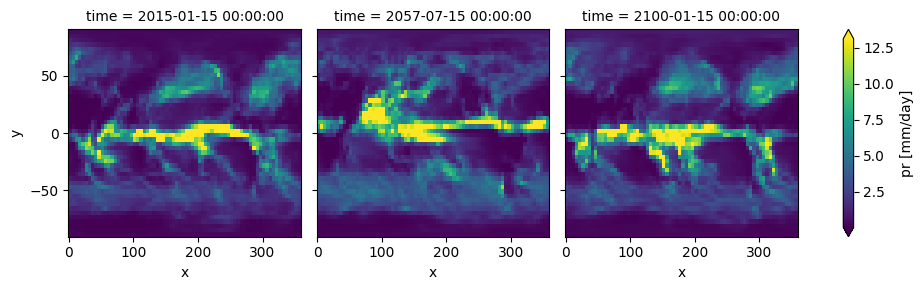

In [3]:
data_subset = data.isel(time=[0, data.time.size // 2, -1]).sel(ssp="ssp370", member_id=0)
data_subset.tas.plot(col="time", x="x", y="y", robust=True)
data_subset.pr.plot(col="time", x="x", y="y", robust=True)

# Plot the time series of global mean temperature and precipitation

Note that we do not plot the SSP245 scenario here, as it is corrupted in the provided data.

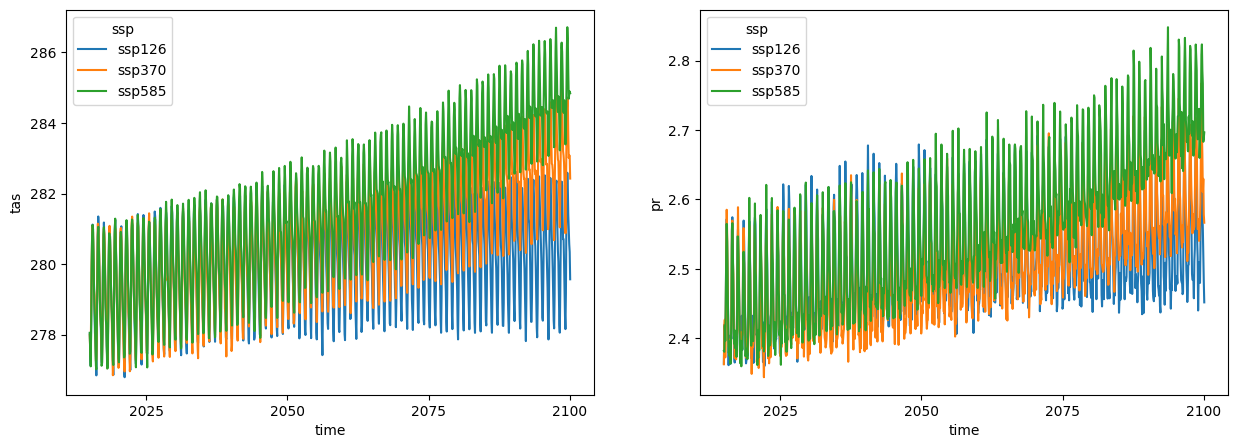

In [4]:
global_mean_data = data.sel(ssp=["ssp126", "ssp370", "ssp585"]).mean(dim=["x", "y", "member_id"])  # also average over all ensemble members
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
global_mean_data.tas.plot(label="Temperature", ax=ax[0], hue="ssp")
global_mean_data.pr.plot(label="Precipitation", ax=ax[1], hue="ssp")# Plot the time series of global mean temperature and precipitation

# Plot the (global mean) time series of climate forcings

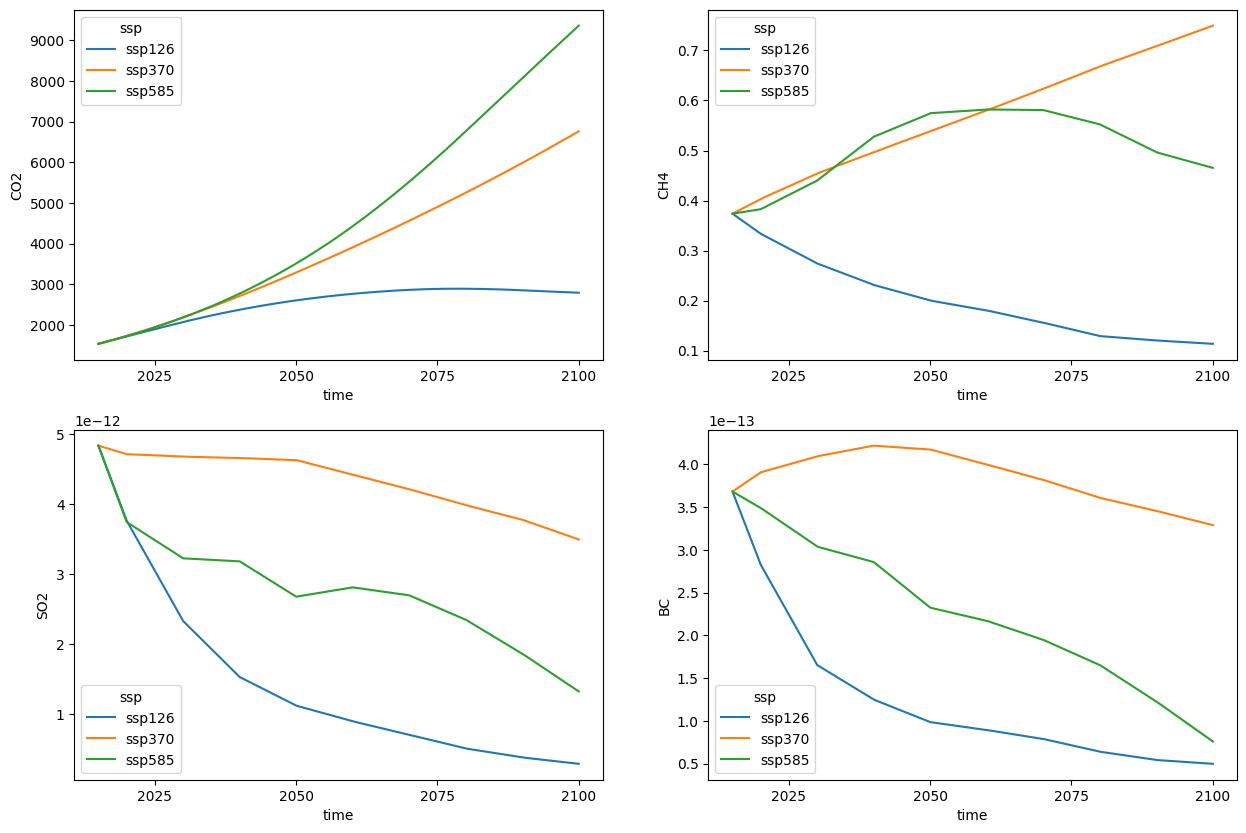

In [5]:
global_mean_data = data.sel(ssp=["ssp126", "ssp370", "ssp585"]).mean(dim=["longitude", "latitude", "member_id"]) 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
global_mean_data.CO2.plot(ax=axes[0], hue="ssp")
global_mean_data.CH4.plot(ax=axes[1], hue="ssp")
global_mean_data.SO2.plot(ax=axes[2], hue="ssp")
_ = global_mean_data.BC.plot(ax=axes[3], hue="ssp")

## snapshot at most recent time

In [ ]:
data_subset = data.isel(time=[0, -1]).sel(ssp=["ssp126", "ssp370", "ssp585"], member_id=0)
data_subset.tas.plot(col="ssp", row="time", x="x", y="y", robust=True)
data_subset.pr.plot(col="ssp", row="time", x="x", y="y", robust=True)